This script can be used to interpret .mat files for a single animal.

In [1]:
# import libraries
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import statistics as stats

In [2]:
# load dataset for animal 24116
fileLoc = "D:\\Data\\Dataset\\24116.mat" # insert your file location here
matfile = sio.loadmat(fileLoc) # read in .mat file as dictionary

# parse matfile
accel = matfile["accel"][0]
behaviour = matfile["behaviour"][0]
hd = matfile["hd"][0]
pos = matfile["pos"][0]
rawEEG = matfile["rawEEG"][0]
sessInfo = matfile["sessInfo"][0]
speed = matfile["speed"][0]
SpikeTimes = matfile["SpikeTimes"][0]
SpikeTrain = matfile["SpikeTrain"][0]
trialType = matfile["trialType"][0]
UniqueID = matfile["UniqueID"][0]

# Manually define home-well locations for each session (I'll incorporate this into the dataset later)
hwLoc = [37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
         37, 37, 37, 36, 37, 36, 36, 36, 36, 37, 37, 37, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37]

C:\Users\17145\Anaconda3\lib\site-packages\scipy\io\matlab\mio.py:224: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [72]:
class dataset:
    
    def __init__(self, animalID, accel, behaviour, hd, pos, rawEEG, sessInfo, speed, SpikeTimes, SpikeTrain, trialType, UniqueID, hwLoc):
        self.animalID = animalID
        self.accel = accel
        self.behaviour = behaviour
        self.hd = hd
        self.pos = pos
        self.rawEEG = rawEEG
        self.sessInfo = sessInfo
        self.speed = speed
        self.SpikeTimes = SpikeTimes
        self.SpikeTrain = SpikeTrain
        self.trialType = trialType
        self.UniqueID = UniqueID
        self.hwLoc = hwLoc

    def getAccel(self, sessNum=0):
        return self.accel[sessNum]

    def getBehaviour(self, sessNum=0):
        return self.behaviour[sessNum][0]
    
    def getHD(self, sessNum=0):
        return self.hd[sessNum][:,0]
    
    def getPos(self, sessNum=0):
        return self.pos[sessNum]
    
    def getRawEEG(self, sessNum=0, chan=0):
        return self.rawEEG[sessNum][0][chan]
    
    def getSessInfo(self, sessNum=0, cat='minX'):
        switcher={
                'winMinX':float(matfile["sessInfo"][0][sessNum][0]["window_min_x"][0][0][0][0]),
                'winMaxX':float(matfile["sessInfo"][0][sessNum][0]["window_max_x"][0][0][0][0]),
                'winMinY':float(matfile["sessInfo"][0][sessNum][0]["window_min_y"][0][0][0][0]),
                'winMaxY':float(matfile["sessInfo"][0][sessNum][0]["window_max_y"][0][0][0][0]),
                'minX':float(matfile["sessInfo"][0][sessNum][0]["min_x"][0][0][0][0]),
                'maxX':float(matfile["sessInfo"][0][sessNum][0]["max_x"][0][0][0][0]),
                'minY':float(matfile["sessInfo"][0][sessNum][0]["min_y"][0][0][0][0]),
                'maxY':float(matfile["sessInfo"][0][sessNum][0]["max_y"][0][0][0][0]),
                'trial_time':matfile["sessInfo"][0][sessNum][0]["trial_time"][0][0][0][0],
                'trial_date':matfile["sessInfo"][0][sessNum][0]["trial_date"][0][0][0][0],
                'duration':float(matfile["sessInfo"][0][sessNum][0]["duration"][0][0][0][0]),
                'num_pos_samples':float(matfile["sessInfo"][0][sessNum][0]["num_pos_samples"][0][0][0][0]),
                'pixels_per_metre':float(matfile["sessInfo"][0][sessNum][0]["pixels_per_metre"][0][0][0][0]),
                'bytes_per_coord':int(matfile["sessInfo"][0][sessNum][0]["bytes_per_coord"][0][0][0][0]),
                'bytesPerTS':int(matfile["sessInfo"][0][sessNum][0]["bytesPerTS"][0][0][0][0]),
                'sampleRate':matfile["sessInfo"][0][sessNum][0]["sampleRate"][0][0][0][0], 
                'EEGsamplesPerPos':int(matfile["sessInfo"][0][sessNum][0]["EEGsamplesPerPos"][0][0][0][0]),
        }
        return switcher.get(
            cat,"Invalid category input. Valid inputs include: 'winMinX', 'winMaxX', 'winMinY', 'winMaxY',\
            'minX', 'maxX', 'minY', 'maxY', 'trial_time', 'trial_date', 'duration', 'num_pos_samples', \
            'pixels_per_metre', 'bytes_per_coord', 'bytesPerTS', 'sampleRate', 'EEGsamplesPerPos'")

    def getSpeed(self, sessNum=0):
        return self.speed[sessNum]
    
    def getSpikeTimes(self, sessNum=0, unitNum=0):
        return self.SpikeTimes[sessNum][0][unitNum]
    
    def getSpikeTrain(self, sessNum=0, unitNum=0):
        return self.SpikeTrain[sessNum][0][unitNum][0]
    
    def getTrialType(self, sessNum=0):
        return self.trialType[sessNum][0]
    
    def getUID(self, sessNum=0, unitNum=0):
        return self.UniqueID[sessNum][0][unitNum][0][0]

    def getHwLoc(self, sessNum=0):
        return self.hwLoc[sessNum]
    
    def getBearingAllo(self, sessNum=0, refLoc=[370, 260]):
        pos_ = self.getPos(sessNum=sessNum)
        xAnimal = pos_[:,1]
        yAnimal = pos_[:,2]
        xRef = refLoc[0]
        yRef = refLoc[1]
        bearingAllo = np.rad2deg(np.arctan2(yRef-yAnimal, xRef-xAnimal)+np.pi)
        return bearingAllo
    
    def getBearingEgo(self, sessNum=0, refLoc=[370, 260]):
        bearingAllo = self.getBearingAllo(sessNum=sessNum, refLoc=refLoc)
        hdAllo = self.getHD(sessNum=sessNum)
        bearingEgo = np.subtract(bearingAllo, hdAllo)
        return bearingEgo
    
    def findWellLoc(self, sessNum=0, testX=370, testY=260):
        pos_ = self.getPos(sessNum=sessNum)
        hwLoc = self.getHwLoc(sessNum=sessNum)
        trialType = self.getTrialType(sessNum=sessNum)
        figTitle = "Type: " + str(trialType) + " Loc: " + str(hwLoc)
        fig = plt.figure()
        ax = fig.add_subplot()
        ax.hlines(y=testY, xmin=150, xmax=600, colors = 'r', linewidth= 3)
        ax.vlines(x=testX, ymin=50, ymax=500, colors = 'r', linewidth = 3)
        ax.plot(pos_[:,1], pos_[:,2], linewidth = .5)
        ax.set_title(label=figTitle)
        return
    
    def classifyUnits(self, sessNum=0):
        ST = self.SpikeTimes[sessNum][0]
        unitList = np.zeros((len(ST), 2))
        for i,t in enumerate(ST):
            unitList[i,0] = i
            unitList[i,1] = len(t)
        return unitList
    
    def angTuningCurve(self, sessNum=0, unitNum=0, refLoc=[370, 260], save=False):
        # get egocentric bearing values (S26,HW27)
        bearingEgo = self.getBearingEgo(sessNum=sessNum, refLoc=refLoc)
        ST = self.getSpikeTrain(sessNum=sessNum, unitNum=unitNum)
        Fs = stats.mode(np.diff(self.getPos(sessNum=sessNum)[:,0])) # sampling freq

        # bin angular data
        numBins = 30 # 12 degree bins
        edges = np.linspace(0, 180, numBins)

        # compute angular occupancy
        occupancy, edgesHist = np.histogram(bearingEgo, bins=30, range=(0,180))
        angInd = np.digitize(bearingEgo, edgesHist);

        # convert hdOccupancy to s
        occupancy = occupancy*Fs

        # compute number of spikes in each time bin
        spikesPerAngle = [];

        # compute number of spikes in each time bin
        for iBin in np.arange(0, numBins):
            spikesPerAngle.append(sum(ST[angInd == iBin]))
        spikesPerAngle = np.asarray(spikesPerAngle)

        # compute probability density (proportion of time spent at each angle)
        probDens = occupancy/np.sum(occupancy)

        # compute average firing rates across all angles
        meanFR = np.sum(spikesPerAngle)/np.sum(occupancy)

        # compute tuning curve (average FR for each angle)
        angularTuning = spikesPerAngle/occupancy
        
        # make figure title
        UID = self.getUID(sessNum=sessNum, unitNum=unitNum)
        figTitle = "UID: " + str(UID) + " Sess: " + str(sessNum) 

        fig, axs = plt.subplots(1, 1, subplot_kw=dict(projection='polar'), figsize = (4,5));
        plt.style.use('seaborn-white')
        axs.plot(edges, angularTuning, color = 'k', linewidth = 1.25);
        axs.yaxis.get_major_locator().base.set_params(nbins=5); # reduce number of y-ticks
        axs.tick_params(axis='x', labelsize=15, colors = 'gray');
        axs.tick_params(axis='y', labelsize=15, colors = 'gray');
        fontStuff = {'fontsize': 15}
        axs.set_title(label=figTitle, fontdict=fontStuff, pad=20)
        
        if save == True:
            filepath = "D:\\egoBearing\\" + str(UID) + "-" + str(sessNum) + ".png" 
            fig.savefig(filepath)

In [73]:
# create instance for animal 24116
A24116 = dataset('24116', accel, behaviour, hd, pos, rawEEG, sessInfo, speed, SpikeTimes, SpikeTrain, trialType, UniqueID, hwLoc)

Text(0.5, 1.0, 'Type: FM Loc: 37')

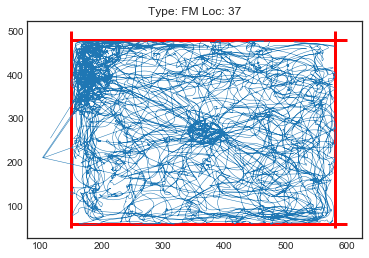

In [109]:
#     def findWellLoc(self, sessNum=0, testX=370, testY=260):
sessNum = 26
pos_ = A24116.getPos(sessNum=sessNum)
hwLoc = A24116.getHwLoc(sessNum=sessNum)
trialType = A24116.getTrialType(sessNum=sessNum)
figTitle = "Type: " + str(trialType) + " Loc: " + str(hwLoc)
fig = plt.figure()
ax = fig.add_subplot()

ax.hlines(y=60, xmin=150, xmax=600, colors = 'r', linewidth= 3)
ax.hlines(y=480, xmin=150, xmax=600, colors = 'r', linewidth= 3)
ax.vlines(x=150, ymin=50, ymax=500, colors = 'r', linewidth = 3)
ax.vlines(x=580, ymin=50, ymax=500, colors = 'r', linewidth = 3)

ax.plot(pos_[:,1], pos_[:,2], linewidth = .5)
ax.set_title(label=figTitle)

C:\Users\17145\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\17145\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


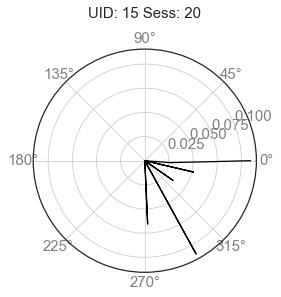

In [122]:
A24116.angTuningCurve(sessNum=SN, unitNum=UN, refLoc=[370, 260], save=True)